## Explore data

In [1]:
# load data
import pandas as pd
data=pd.read_csv('cookie_cats.csv')

In [2]:
# check data and missing values
data.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
data.isnull().sum()
# there is no missing value

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [4]:
# count the number of players for control group and test group
data.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


The number of players in the control group is roughly the same as that in the test group.

## **Explore player behavior**

In [5]:
# visualize how many rounds people played
data['sum_gamerounds'].plot.box(figsize=(5,10))

We spot an outlier which is 50,000.

In [6]:
data['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [7]:
# count the number of the users group by gamerounds, then we can use it to plot the distribution
data_plot=data.groupby('sum_gamerounds')['userid'].count()

In [8]:
data_plot.head(6)

sum_gamerounds
0    3994
1    5538
2    4606
3    3958
4    3629
5    2992
Name: userid, dtype: int64

25% players played less than 5 rounds after downloading, 50% players played less than 16 rounds.<br>
It's noticeable that 3994 users downloaded the game but didn't play a single round.<br>
    There are some potential reasons: <br>
    (1) They had technical issues opening the game.<br>
    (2) They have not started playing the game.<br>
    (3) They opened the game but not interested in the interface/design, so they quitted.<br>
    ...<br>
    It's essential to understand why our customers left at a early stage by doing surveys or collecting feedbacks.<br>

Text(0.5, 0, 'Gamerounds')

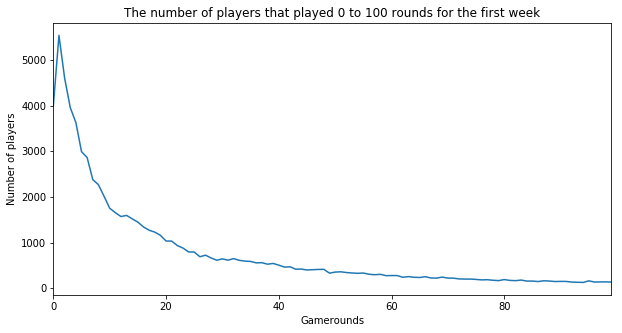

In [9]:
%matplotlib inline
# plot the distribution of players that played 0 to 100 rounds
pl=data_plot[:100].plot(figsize=(10,5))
pl.set_title('The number of players that played 0 to 100 rounds for the first week')
pl.set_ylabel('Number of players')
pl.set_xlabel('Gamerounds')

Huge number of players played for less than 10 rounds and left the game. The number of playered stayed steady after 60 rounds.

## **Comparing 1 day retention**

In [10]:
# overall retention
data['retention_1'].sum()/data['retention_1'].count()

0.4452095044850259

Less than 50% players come back and play the game after installing the game.

### 1-day retention for A/B groups

In [11]:
# check how it works for different groups
data.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

The retention rate under version gate_30 (44.8188%) is slightly higher than the rate under version gate_40 (44.2283%).<br>
We will use bootstrapping to determine whether the difference in rentention rates has a great impact.<br>
**Bootstrapping: we repeatedly re-sample our dataset(with replacement) and calculate 1-day retention for those samples.** The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

#### Bootstrapping ####

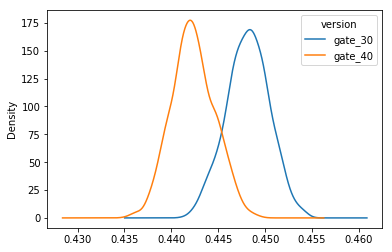

In [12]:
# bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = data.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# transform data into dataframe
boot_1d = pd.DataFrame(boot_1d)

# bootstrap distribution
boot_1d.plot(kind='density')

Text(0.5, 1.0, '% difference in 1-day retention between two versions')

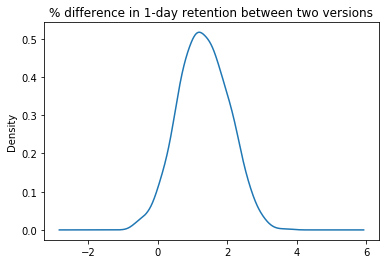

In [13]:
# plot the %difference
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100
diff = boot_1d['diff'].plot(kind='density')
diff.set_title('% difference in 1-day retention between two versions')

In [14]:
# probability that 1-day retention under gate level 30 is greater than the retention under gate level 40
(boot_1d['diff']>0).mean()

0.973

95.8% of the distribution is above 0, meaning that version gate 30 is greater than version gate 40.

## Comparing 7-day Retention

In [15]:
data.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Findings:
1. Overall 7-day retention rates are lower than 1-day retention rates.
2. Retention rate under version gate_30 (19.02%) is slightly higher than that under version gate_40 (18.20%).

### Bootstrapping

In [16]:
boot_7d = []
for i in range(500):
    boot_mean = data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
boot_7d  = pd.DataFrame(boot_7d)

In [17]:
# add the difference column
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

Text(0.5, 1.0, '% difference in 7-day retention between two versions')

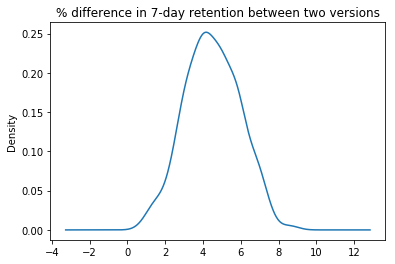

In [18]:
# plot the difference
diff_7 = boot_7d['diff'].plot(kind='density')
diff_7.set_title('% difference in 7-day retention between two versions')

In [19]:
# probability that 7-day retention under level 30 is greater than the retention under level 40
(boot_7d['diff']>0).mean()

1.0

100% distribution of the difference is above 0.

## Conclusion

  7-day retention is higher when the first gate in Cookie Cats is at level 30 than at level 40. So we shouldn't move the gate from level 30 to level 40.<br>
  <br>
Why is the retention rate higher when the gate is positioned at level 30 than at level 40?<br><br>
**Hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously.** <br><br>By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But **when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it**.
    